# Setup

**Imports**

In [ ]:
import datetime as dt
from math import log
import IPython

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from scipy.signal import chirp, stft, sweep_poly, spectrogram
from ruptures.costs import CostCLinear
from kneed import KneeLocator
import scipy


import geopandas
import contextily as cx
from pyproj.crs import CRS
from osgeo.osr import SpatialReference
CRS = "EPSG:4326"
osr_crs = SpatialReference()
osr_crs.ImportFromEPSG(int(CRS.split(":")[1]))


rng = np.random.default_rng()

**Utility functions**

In [ ]:
tones = {"1": (697, 1209), "2": (697, 1336), "3": (697, 1477), "4": (770, 1209), "5": (770, 1336), "6": (770, 1477), "7": (852, 1209), "8": (852, 1336), "9": (852, 1477), "0": (941, 1336), "*": (941, 1209), "#": (941, 1477), "A": (697, 1633), "B": (770, 1633), "C": (852, 1633), "D": (941, 1633)}
FS = 22_050  # Hz
sigma = 2


def generate_symbol(symbol, duration, fs):
    """Generate the sound for number with given duration"""
    # get both frequencies for the symbol
    f1, f2 = tones[symbol]
    # time array
    time_arr = np.arange(0, duration, 1 / fs)
    # audio signal
    signal = np.cos(2 * np.pi * f1 * time_arr) + np.cos(2 * np.pi * f2 * time_arr)
    return signal

def generate_signal():
    n_symbols = rng.integers(3, 12)
    list_of_symbols = rng.choice(list("1234567890*#ABCD"), size=n_symbols)

    list_of_segments = list()

    for symbol in list_of_symbols:
        duration = rng.uniform(low=0.05, high=0.2)  # seconds
        # generate tone
        symbol_signal = generate_symbol(symbol=symbol, duration=duration, fs=FS)
        # generate silence
        silence = np.zeros(int(duration*FS))
        # append tone and silence
        list_of_segments.extend([symbol_signal, silence])

    # silence at the start
    silence = np.zeros(int(duration*FS))
    list_of_segments = [silence] + list_of_segments

    signal = np.concatenate(list_of_segments)
    n_samples = signal.shape[0]
    time_array = np.arange(n_samples) / FS
    
    # add nuissance
    inst_freq = np.sin(2 * np.pi * 1.2 * time_array) * 1500 + 2000
    poly = np.polyfit(x=time_array, y=inst_freq, deg=14)
    sin_freq = sweep_poly(time_array, poly)
    signal += sin_freq
    # add white noise
    signal += rng.normal(scale=sigma, size=n_samples)

    return signal, list_of_symbols.tolist()


# Question 1


[Dual-tone multi-frequency signaling](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling) is a procedure to encode symbols using audio signal.

A symbold is represented by a sum of cosine waves: for $t=0,1,\dots,T-1$,

$$
y_t = \cos(2\pi f_1 t/f_s) + \cos(2\pi f_2 t/f_s)
$$
where each combination of $(f_1, f_2)$ represents a symbols (see table below).


|         | 1209 Hz  | 1336 Hz  | 1477 Hz  | 1633 Hz  |
|---------|----------|----------|----------|----------|
| **697 Hz**  | 1        | 2        | 3        | A        |
| **770 Hz**  | 4        | 5        | 6        | B        |
| **852 Hz**  | 7        | 8        | 9        | C        |
| **941 Hz**  | *        | 0        | #        | D        |

In [ ]:
signal, symbols = generate_signal()
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

# 6 6 9 3 8


In [ ]:
def get_bkps(signal_tf, max_bkps):
    all_errors = list()
    all_bkps = list()
    algo = rpt.Dynp().fit(signal_tf)
    for n_bkp in range(1, max_bkps+1):
        bkps = algo.predict(n_bkps=n_bkp)
        error = algo.cost.sum_of_costs(bkps)
        all_errors.append(error)
        all_bkps.append(bkps)

    kn = KneeLocator(range(max_bkps), np.array(all_errors).squeeze(), curve='convex', direction='decreasing')
    bkps = all_bkps[kn.knee]
    return bkps, all_errors, kn.knee

def get_sound_freq(signal_tf, bkps):
    mean_freq_per_bkp = list()
    idx_0 = []
    idx_1 = []
    for i in range(len(bkps)):
        if i == 0:
            tmp = signal_tf[:bkps[i]].mean(0)
        else:
            tmp = signal_tf[bkps[i-1]:bkps[i]].mean(0)
        mean_freq_per_bkp.append(tmp)
    max_freq_noise = np.array(mean_freq_per_bkp)[:,21:].max()
    for tmp in mean_freq_per_bkp:
        tmp_idx_0 = np.argmax(tmp)
        if tmp[tmp_idx_0] < max_freq_noise:
            idx_0.append(0)
            idx_1.append(0)
            continue
        tmp[tmp == np.max(tmp)] = 0
        tmp_idx_1 = np.argmax(tmp)
        if tmp_idx_0 > tmp_idx_1:
            tmp_idx_0, tmp_idx_1 = tmp_idx_1, tmp_idx_0
        idx_0.append(tmp_idx_0)
        idx_1.append(tmp_idx_1)
    
    return idx_0, idx_1, mean_freq_per_bkp

def find_closest_freq(freq, list_of_freq):
    return list_of_freq[np.argmin(np.abs(np.array(list_of_freq) - freq))], np.min(np.abs(np.array(list_of_freq) - freq))

def decode_idx(idx_0, idx_1, list_of_freq_0, list_of_freq_1, verbose=False):
    res = []
    for i in range(len(idx_0)):
        f1, f1_err = find_closest_freq(f[idx_0[i]], list_of_freq_0)
        f2, f2_err = find_closest_freq(f[idx_1[i]], list_of_freq_1)
        if f1_err > 50 or f2_err > 50:
            if verbose:
                print(f"SILENCE ->  {max(f1_err, f2_err)}")
        else:
            if verbose:
                print(f"bkp {i}: {f1} {f2}")
            key = next(key for key, value in tones.items() if value == (f1, f2))
            res.append(key)
    return res

The original signal is # 6 6 9 3 8
The decoded signal is  # 6 9 3 8


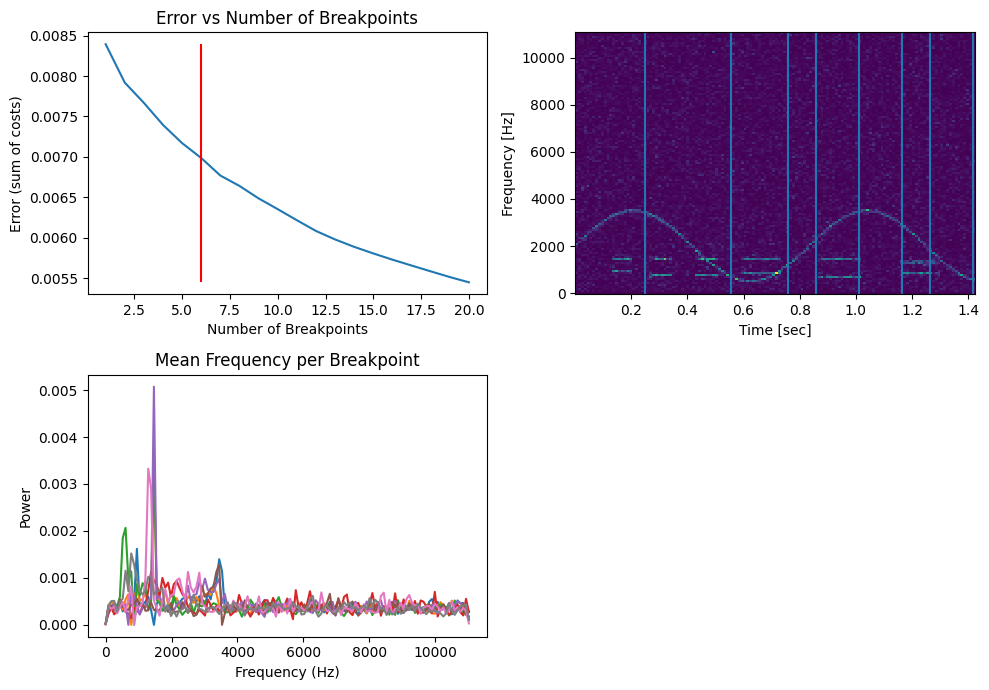

In [ ]:
f, t, Sxx = spectrogram(signal, FS)
signal_tf = np.abs(Sxx).T
max_bkps = 20
    
bkps, all_errors, n_bkps = get_bkps(signal_tf, max_bkps)
idx_0, idx_1, mean_freq_per_bkp = get_sound_freq(signal_tf, bkps)
first_dim = [697, 770, 852, 941]
second_dim = [1209, 1336, 1477, 1633]
res = decode_idx(idx_0, idx_1, first_dim, second_dim, verbose=False)
print(f'The original signal is {" ".join(symbols)}')
print(f'The decoded signal is  {" ".join(res)}')

fig, ax = plt.subplots(2, 2, figsize=(10, 7))
ax[0,0].plot(range(1,max_bkps+1), all_errors)
ax[0,0].vlines(n_bkps, min(all_errors), max(all_errors), color="red")
ax[0,0].set_title("Error vs Number of Breakpoints")
ax[0,0].set_xlabel("Number of Breakpoints")
ax[0,0].set_ylabel("Error (sum of costs)")

ax[0,1].pcolormesh(t, f, Sxx)
ax[0,1].set_ylabel('Frequency [Hz]')
ax[0,1].set_xlabel('Time [sec]')
for b in bkps:
    ax[0,1].axvline(t[b-1])

for i in range(len(bkps)):
    ax[1,0].plot(f, mean_freq_per_bkp[i], label=f"bkp {i}")
ax[1,0].set_title("Mean Frequency per Breakpoint")
ax[1,0].set_xlabel("Frequency (Hz)")
ax[1,0].set_ylabel("Power")

ax[1,1].axis("off")
fig.tight_layout()




# Question 2

In [ ]:
sound_1 = np.loadtxt("signal_1.csv")
sound_2 = np.loadtxt("signal_2.csv")

In [ ]:
f, t, Sxx = spectrogram(sound_1, FS)
signal_tf = np.abs(Sxx).T
max_bkps = 40
    
bkps, all_errors, n_bkps = get_bkps(signal_tf, max_bkps)
idx_0, idx_1, mean_freq_per_bkp = get_sound_freq(signal_tf, bkps)
res = decode_idx(idx_0, idx_1, first_dim, second_dim, verbose=False)
print(" --- Signal 1 --- ")
print(f'The decoded signal is {" ".join(res)}')

f, t, Sxx = spectrogram(sound_2, FS)
signal_tf = np.abs(Sxx).T
max_bkps = 30
    
bkps, all_errors, n_bkps = get_bkps(signal_tf, max_bkps)
idx_0, idx_1, mean_freq_per_bkp = get_sound_freq(signal_tf, bkps)
res = decode_idx(idx_0, idx_1, first_dim, second_dim, verbose=False)
print(" --- Signal 2 --- ")
print(f'The decoded signal is {" ".join(res)}')


 --- Signal 1 --- 
The decoded signal is B 9 4 B 3 1
 --- Signal 2 --- 
The decoded signal is C D 1 1 6 3


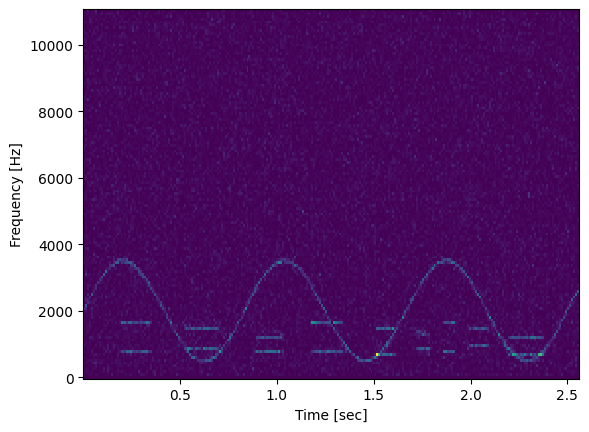

In [ ]:
f, t, Sxx = spectrogram(sound_1, FS)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

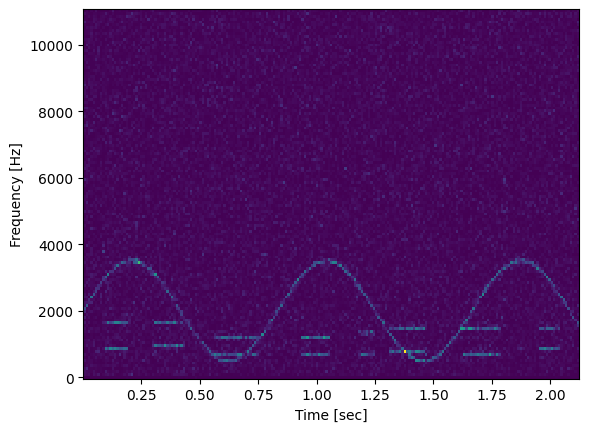

In [ ]:
f, t, Sxx = spectrogram(sound_2, FS)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# Question 3

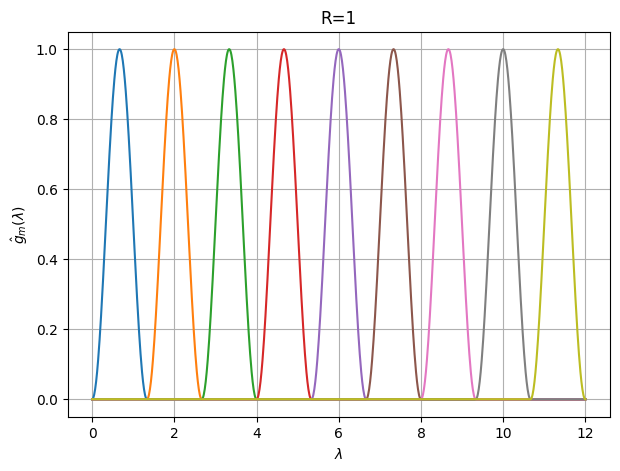

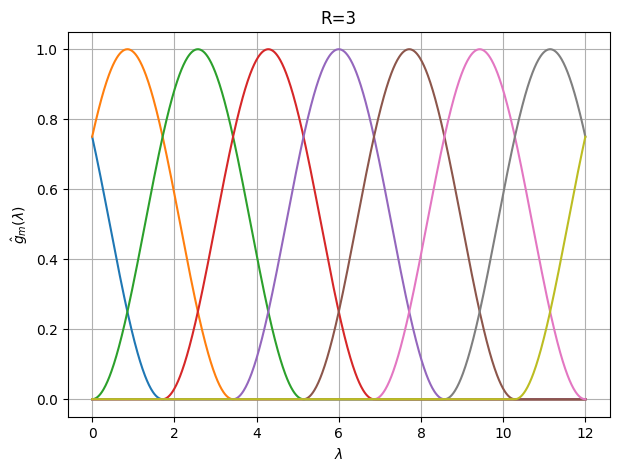

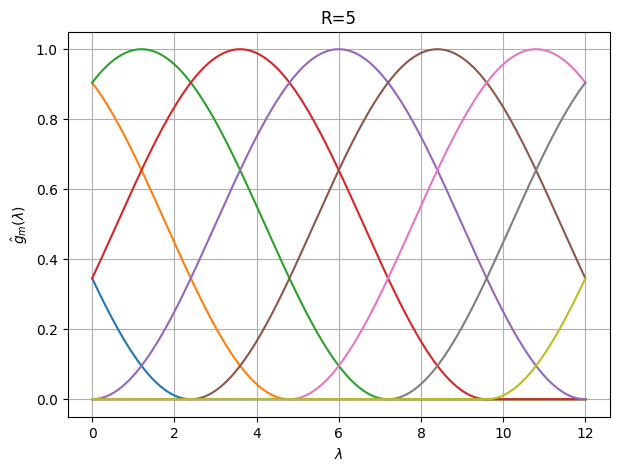

In [ ]:
def compute_g(lambda_n, R, n_points=1000):
    M = 9
    a = lambda_n/(M+1-R)
    g = np.zeros((M, n_points))
    lbd = np.linspace(0, lambda_n, n_points)
    for m in range(1, M+1):
        curr_lbd = lbd-a*m
        tmp = 1+np.cos(2*np.pi*(curr_lbd/(a*R)+0.5))
        g[m-1, :] = np.where(np.logical_and(curr_lbd<0, curr_lbd>=-a*R), tmp, 0)
    return 0.5*g

lambda_n = 12
n_points=1000
for i, R in enumerate([1, 3, 5]):
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    g = compute_g(lambda_n, R, n_points=n_points)
    for m in range(g.shape[0]):
        ax.plot(np.linspace(0, lambda_n, n_points),g[m], label=f"m={m+1}")
    ax.set_title(f"R={R}")
    ax.set_xlabel(r"$\lambda$")
    ax.set_ylabel(r"$\hat{g}_m(\lambda)$")
    ax.grid()
    plt.savefig(f"fig_{i}_q_3.png")
    plt.show()

# Question 4

In [ ]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from pygsp import graphs
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform
from math import asin, cos, radians, sin, sqrt
from matplotlib.dates import DateFormatter
import pandas as pd


def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

data_df, stations_df, description = load_molene_meteo_dataset()

In [ ]:
# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius
temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)
# drop stations with missing values
print(temperature_df.columns[temperature_df.isna().any()].tolist())
temperature_df.dropna(axis=1, inplace=True)
stations_df = stations_df[stations_df['Nom'].isin(temperature_df.columns)]

['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET', 'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA', 'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN', 'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON']


In [ ]:
# Compute the graph using distance matrix and exponential smoothing
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = 0.8
adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
G_gaussian
print(
    f"The graph is {'not ' if not G_gaussian.is_connected(recompute=True) else ''}connected, with {G_gaussian.N} nodes, {G_gaussian.Ne} edges"
)
print("The mean degree is", round(G_gaussian.d.mean(), 3))

The graph is connected, with 37 nodes, 89 edges
The mean degree is 4.811


In [1]:

laplacian_matrix = G_gaussian.L.todense()


signals = temperature_df.to_numpy()
smoothness_arr = np.array(
    [float(signal.T.dot(laplacian_matrix).dot(signal)) for signal in signals]
)
smoothness_df = pd.Series(
    data=smoothness_arr, index=temperature_df.index
)
"""
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
smoothness_df.plot(ax=ax)
myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")
"""
least_smooth_idx = np.argmax(smoothness_arr)
most_smooth_idx = np.argmin(smoothness_arr)
print('The least smooth signal is from', temperature_df.index[least_smooth_idx])
print('The smoothest signal is from', temperature_df.index[most_smooth_idx])


NameError: ignored

# Question 5

In [ ]:
from scipy.linalg import eigh
least_smooth_signal = signals[least_smooth_idx]
most_smooth_signal = signals[most_smooth_idx]
first_signal = temperature_df.iloc[0].to_numpy()

R = 3

laplacian_matrix = G_gaussian.L.todense()
lambda_l, u_l = eigh(laplacian_matrix)

In [ ]:
def compute_g(lambda_n, R, n_points=1000):
    M = 9
    a = lambda_n/(M+1-R)
    g = np.zeros((M, n_points))
    lbd = np.linspace(0, lambda_n, n_points)
    for m in range(1, M+1):
        curr_lbd = lbd-a*m
        tmp = 1+np.cos(2*np.pi*(curr_lbd/(a*R)+0.5))
        g[m-1, :] = np.where(np.logical_and(curr_lbd<0, curr_lbd>=-a*R), tmp, 0)
    return 0.5*g

def compute_W(lambda_l, f, u_l, R, idx_node):
    M = 9
    W_f = []
    a = lambda_l.max()/(M+1-R)    
    for m in range(1, M+1):
        g = np.zeros(len(lambda_l))
        curr_lbd = lambda_l-a*(m)
        tmp = 1+np.cos(2*np.pi*(curr_lbd/(a*R)+0.5))
        g = np.where(np.logical_and(curr_lbd<0, curr_lbd>=-a*R), tmp, 0)
        f_four = u_l.T.dot(f)
        W = 0.5*g*f_four*u_l[:, idx_node]
        W_f.append(W.sum().copy())
    return W_f

def compute_class(signal, lambda_l, u_l, R):
    W_f = []
    for node in range(signal.shape[0]):
        W_f.append(compute_W(lambda_l, signal, u_l, R, node))

    W_f = np.array(W_f)
    W_f_square  = np.square(W_f)
    energy_0_3 = W_f_square[:, 0:3].sum(axis=1)
    energy_3_6 = W_f_square[:, 3:6].sum(axis=1)
    energy_6_9 = W_f_square[:, 6:9].sum(axis=1)
    node_class = np.argmax(np.stack([energy_0_3, energy_3_6, energy_6_9]), axis=0)
    return node_class

In [ ]:
names = ['least_smooth_signal', 'most_smooth_signal', 'first_signal']
signals = [least_smooth_signal, most_smooth_signal, first_signal]


In [ ]:
for i, signal in enumerate(signals):
    node_class = compute_class(signal, lambda_l, u_l, R)
    stations_gdf = geopandas.GeoDataFrame(
        stations_df,
        geometry=geopandas.points_from_xy(
            stations_df.Longitude, stations_df.Latitude
        ),
    ).set_crs(CRS)

    colors = ["b", "m", "r"]
    cols = [colors[i] for i in node_class]
    ax = stations_gdf.geometry.plot(figsize=(10, 5), c=cols)
    cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
    ax.set_axis_off()
    plt.savefig(f"{names[i]}.png", dpi=300, bbox_inches="tight")
    plt.close()


# Question 6

In [ ]:
q_6_col_array = []
q_6_y = []
q_6_x = []
for i in range(len(temperature_df)):
    curr_signal = temperature_df.iloc[i].to_numpy()
    node_class = compute_class(curr_signal, lambda_l, u_l, R)
    mean_temp = curr_signal.mean()
    maj_class = np.argmax(np.bincount(node_class))
    q_6_col_array.append(maj_class)
    q_6_y.append(mean_temp)
    q_6_x.append(temperature_df.index[i])


In [ ]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.margins(x=0)
    return fig, ax

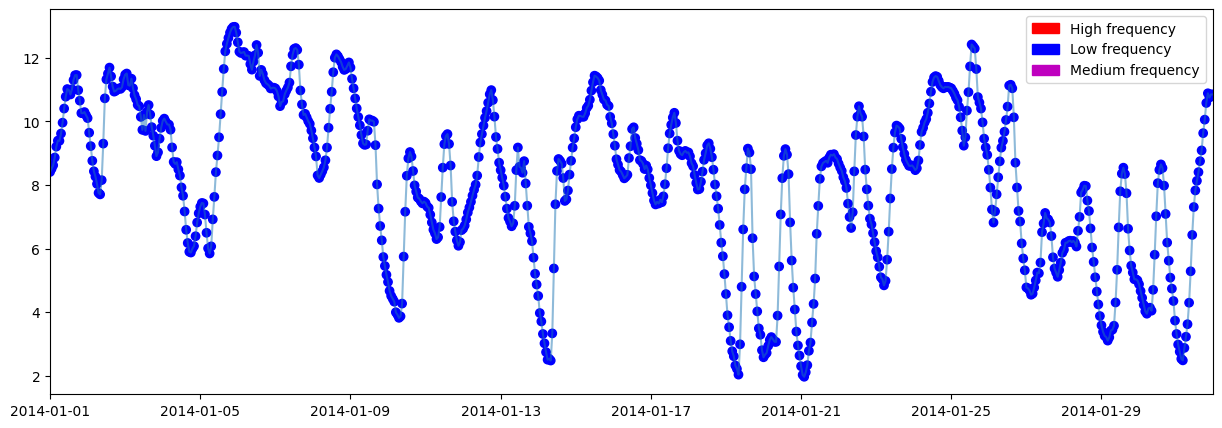

In [ ]:
import matplotlib.patches as mpatches
from matplotlib.patches import Circle
y = q_6_y
x = q_6_x  
class_array = np.array(q_6_col_array)

colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, class_array)
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
red_patch = mpatches.Patch(color='red', label='High frequency')
blue_patch = mpatches.Patch(color='blue', label='Low frequency')
magenta_patch = mpatches.Patch(color='m', label='Medium frequency')
ax.scatter(x, y, c=color_array);
ax.legend(handles=[red_patch, blue_patch, magenta_patch])
plt.savefig("q_6.png", dpi=300, bbox_inches="tight")
# do not forget to explain the colours in the report

# Question 7

$G$ and $G'$ have the same dimension $d$, so 
$$
H = G \otimes I_d + I_d \otimes  G' 
$$ 
Let $\lambda$ and $\mu$ be the eigenvalues of $G$ and $G'$, and $\nu$ the eigenvalues of $H$. We have
$$
\nu = \lambda_i + \mu_j \qquad i\in \{1,\dots, d\},j\in \{1,\dots, d\}
$$ 
and the eigenvectors are given by the Kronecker product of the eigenvectors of $G$ and $G'$

In [ ]:
laplacian_matrix_G = G_gaussian.L.todense()
lambda_l_G, u_l_G = eigh(laplacian_matrix_G)
laplacian_matrix_G_prime = scipy.sparse.diags([1, 2, 1], [-1, 0, 1], shape=(temperature_df.shape[0], temperature_df.shape[0])).toarray()
laplacian_matrix_G_prime[0, 0] = 1
laplacian_matrix_G_prime[-1, -1] = 1
lambda_l_G_prime, u_l_G_prime = eigh(laplacian_matrix_G_prime)



In [ ]:
XX,YY = np.meshgrid(np.arange(temperature_df.shape[0]),np.arange(temperature_df.shape[1]))
signal = temperature_df.to_numpy().flatten()
table = np.vstack((signal.ravel(),XX.ravel(),YY.ravel())).T
table = pd.DataFrame(table,columns=['signal','x','y'])

In [ ]:
import gc
lambda_l_H = []
u_l_H = []
f_four = []
gc.collect()
for tau in range(lambda_l_G_prime.shape[0]):
    for nu in range(lambda_l_G.shape[0]):
        lambda_l_H.append(lambda_l_G[nu] + lambda_l_G_prime[tau])
        # u_l_H.append(np.kron(u_l_G[:, nu],u_l_G_prime[:, tau]))
        u_l_H.append(np.kron(u_l_G_prime[:, tau], u_l_G[:, nu]))
lambda_l_H = np.array(lambda_l_H)
u_l_H = np.array(u_l_H).T

f_four = u_l_H.dot(table.signal)

In [ ]:
def compute_W_spatio_temp(signal, u_l_H, lambda_l_H, M, R, idx_node):
    lambda_max = lambda_l_H.max()
    a = lambda_max/(M+1-R)
    W_f = []
    # f_four = u_l_H.T.dot(signal)
    for m in range(1, M+1):
        g = np.zeros(lambda_l_H.shape[0])

        # for tau in range(lambda_l_G_prime.shape[0]):
        #     for nu in range(lambda_l_G.shape[0]):
        #         lambda_l_H = lambda_l_G[nu] + lambda_l_G_prime[tau]
        #         u_l_H = np.kron(u_l_G_prime[:, tau], u_l_G[:, nu])
        curr_lbd = lambda_l_H-a*(m)
        tmp = 1+np.cos(2*np.pi*(curr_lbd/(a*R)+0.5))
        g = np.where(np.logical_and(curr_lbd<0, curr_lbd>=-a*R), tmp, 0)
        W = 0.5*g*f_four*u_l_H[:,idx_node]
        W_f.append(W.sum())
    return np.array(W_f)

In [ ]:
from tqdm import tqdm
M = 9
R= 3
res = []
for i in tqdm(range(len(table))):
    res.append(compute_W_spatio_temp(table['signal'], u_l_H=u_l_H, lambda_l_H=lambda_l_H, M=M, R=R, idx_node=i))


100%|██████████| 27528/27528 [01:43<00:00, 266.68it/s]


In [ ]:
new_matrix = np.zeros(temperature_df.shape, dtype=int)
for i in range(len(res)):
    energy_0_3 = np.square(res[i][0:3]).sum()
    energy_3_6 = np.square(res[i][3:6]).sum()
    energy_6_9 = np.square(res[i][6:9]).sum()
    new_matrix[int(table['x'][i]), int(table['y'][i])] = np.argmax([energy_0_3, energy_3_6, energy_6_9])


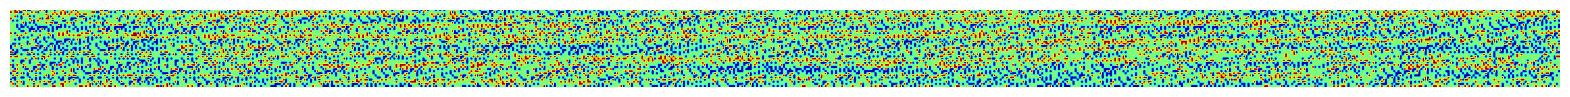

In [ ]:
plt.figure(figsize=(20, 10))
plt.imshow(new_matrix.T, cmap='jet')
plt.axis('off');

In [ ]:
np.bincount(new_matrix.flatten())

array([ 5599, 18075,  3854])

In [ ]:
dominant_class = []
for i in range(len(temperature_df)):
    dominant_class.append(np.argmax(np.bincount(new_matrix[i])))
dominant_class = np.array(dominant_class)
print(dominant_class)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
  
lambda_max = lambda_l_G.max() + lambda_l_G_prime.max()
a = lambda_max/(M+1-R)
W_f = []
for tau in range(lambda_l_G_prime.shape[0]):
    W_f_tau = []
    for nu in range(lambda_l_G.shape[0]):
        W_f_tau_nu = []
        lambda_l_H = lambda_l_G[nu] + lambda_l_G_prime[tau]
        u_l_H = np.kron(u_l_G_prime[:, tau], u_l_G[:, nu])
        f_four = u_l_H.dot(signal)
        tmp_W_f = []
        for m in range(1, M+1):
            g = np.zeros(len(u_l_H))
            curr_lbd = lambda_l_H-a*(m)
            tmp = 1+np.cos(2*np.pi*(curr_lbd/(a*R)+0.5))
            g = np.where(np.logical_and(curr_lbd<0, curr_lbd>=-a*R), tmp, 0)
            W = 0.5*g*f_four*u_l_H[tau*lambda_l_G.shape[0]+nu]
            tmp_W_f = W.sum().copy()
            W_f_tau_nu.append(tmp_W_f)
        W_f_tau.append(np.array(W_f_tau_nu))
    W_f.append(np.array(W_f_tau))
W_f = np.array(W_f)

In [ ]:
W_f = np.array(W_f)
W_f_square  = np.square(W_f)
print(W_f_square.shape)
energy_0_3 = W_f_square[:, :, 0:3].sum(axis=2)
energy_3_6 = W_f_square[:, :, 3:6].sum(axis=2)
energy_6_9 = W_f_square[:, :, 6:9].sum(axis=2)
node_class = np.stack([energy_0_3, energy_3_6, energy_6_9])
node_class = np.argmax(node_class, axis=0)
node_class

(744, 37, 9)


array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]])

In [ ]:
dominant_class = []
for i in range(node_class.shape[0]):
    dominant_class.append(np.argmax(np.bincount(node_class[i])))
dominant_class = np.array(dominant_class)
print(dominant_class)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

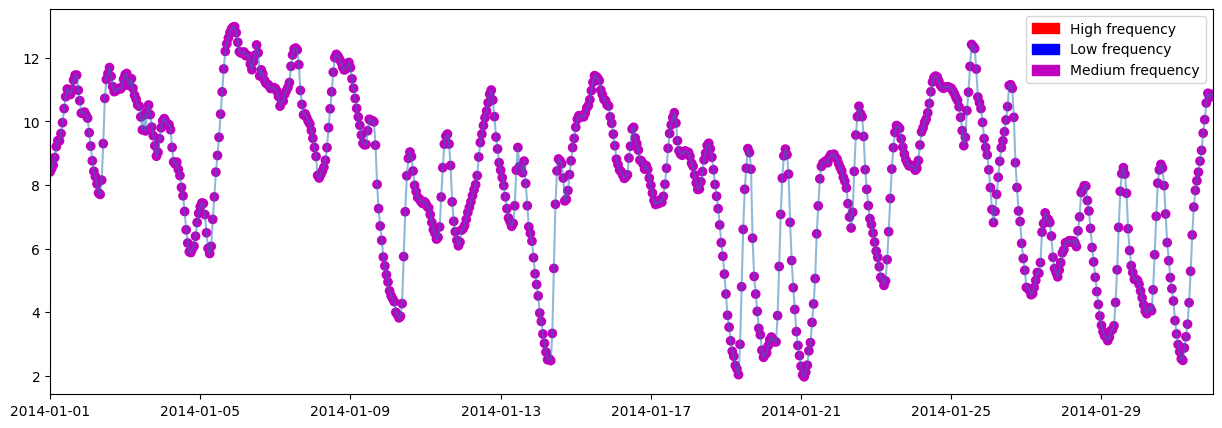

In [ ]:
y = q_6_y
x = q_6_x  
class_array = np.array(dominant_class)

colors = ["b", "m", "r"]  # three colours=three classes
color_array = np.take(colors, class_array)
fig, ax = fig_ax()
ax.plot(x, y, alpha=0.5)
red_patch = mpatches.Patch(color='red', label='High frequency')
blue_patch = mpatches.Patch(color='blue', label='Low frequency')
magenta_patch = mpatches.Patch(color='m', label='Medium frequency')
ax.scatter(x, y, c=color_array);
ax.legend(handles=[red_patch, blue_patch, magenta_patch])
plt.savefig("q_6.png", dpi=300, bbox_inches="tight")
# do not forget to explain the colours in the report